In [ ]:
import pandas as pd
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import ZZFeatureMap
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from qiskit import QuantumCircuit

In [204]:
def load_data_from_mongo(sample_limit=None,
                        num_labels=None,
                        uri="mongodb://localhost:27017/", 
                        db_name="Doodle_Classifier", 
                        collection_name="Filtered_Features",
                        ):
    try:
        client = MongoClient(uri)
        collection = client[db_name][collection_name]

        data = []
        
        # Get unique labels first
        all_unique_labels = collection.distinct("label")
        
        # Determine which labels to use
        if num_labels:
            if num_labels > len(all_unique_labels):
                print(f"Warning: Requested {num_labels} labels but only {len(all_unique_labels)} available")
                labels_to_use = all_unique_labels
            else:
                # Take first num_labels (you could randomize this if needed)
                labels_to_use = all_unique_labels[:num_labels]
                print(f"Using {num_labels} labels out of {len(all_unique_labels)} available")
        else:
            labels_to_use = all_unique_labels
            
        print(f"Selected labels: {labels_to_use}")
        
        if sample_limit:
            samples_per_label = sample_limit // len(labels_to_use)
            
            print(f"Found {len(all_unique_labels)} total unique labels")
            print(f"Using {len(labels_to_use)} labels")
            print(f"Sampling {samples_per_label} samples per label")
            
            # Sample equally from each selected label
            for label in labels_to_use:
                cursor = collection.find({"label": label}).limit(samples_per_label)
                for doc in cursor:
                    row = {
                        'label': doc["label"],
                        **doc["features"]
                    }
                    data.append(row)
        else:
            # Load all data for selected labels
            cursor = collection.find({"label": {"$in": labels_to_use}})
            for doc in cursor:
                row = {
                    'label': doc["label"],
                    **doc["features"]
                }
                data.append(row)
        
        client.close()
        
        if not data:
            raise ValueError("No data found in the collection")
            
        df = pd.DataFrame(data)
        X = df.drop(columns=['label']).values.astype(float)
        y = df['label'].values
        
        # Print label distribution
        unique_labels_loaded = np.unique(y, return_counts=True)
        print(f"Loaded {len(X)} samples with {X.shape[1]} features")
        print("Label distribution:")
        for label, count in zip(unique_labels_loaded[0], unique_labels_loaded[1]):
            print(f"  {label}: {count} samples")
            
        return X, y, df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

In [205]:
X,y,df = load_data_from_mongo(sample_limit=500,num_labels=4)

features_X = StandardScaler().fit_transform(X)
features = X

labels = y
encoded_labels = LabelEncoder().fit_transform(labels)

labels = encoded_labels

Using 4 labels out of 8 available
Selected labels: ['bicycle', 'car', 'clock', 'fish']
Found 8 total unique labels
Using 4 labels
Sampling 125 samples per label
Loaded 500 samples with 19 features
Label distribution:
  bicycle: 125 samples
  car: 125 samples
  clock: 125 samples
  fish: 125 samples


In [206]:
# Min Max plot
# features_minmax = MinMaxScaler().fit_transform(X)


# df = pd.DataFrame(features_minmax, columns=[f"feature_{i}" for i in range(features_minmax.shape[1])])
# df["class"] = pd.Series(labels)

# sns.pairplot(df, hue="class", palette="tab10")
# # save the plot as a image
# import matplotlib.pyplot as plt

# plt.savefig("MinMax_pairplot800.png")

In [207]:
# Standard Scalar
# features_standard = StandardScaler().fit_transform(X)

# df = pd.DataFrame(features_standard, columns=[f"feature_{i}" for i in range(features_standard.shape[1])])
# df["class"] = pd.Series(labels)

# sns.pairplot(df, hue="class", palette="tab10")
# save the plot as a image
# plt.savefig("StandardScaler_pairplot800.png")

In [208]:
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [209]:
svc = SVC()
svc.fit(train_features, train_labels)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [210]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.34
Classical SVC on the test dataset:     0.29


In [211]:
model =  MLPClassifier(max_iter=100)

model.fit(train_features, train_labels)
y_pred = model.predict(test_features)

print("Accuracy:", accuracy_score(test_labels, y_pred))

Accuracy: 0.31


In [232]:
def basis_encoding(vector,qubit_precision=None):
    
    # norm = np.linalg.norm(vector)
    # if norm == 0:
    #     raise ValueError("Zero vector cannot be normalized")
    # normalized = vector / norm

    # # Create a quantum circuit
    # qc = QuantumCircuit(len(vector))
    # qc.initialize(normalized, range(len(vector)))
    # return qc
    
    vector = np.array(vector, dtype=float)
    vector_norm = np.linalg.norm(vector)
    if vector_norm == 0:
        raise ValueError("Input vector cannot be all zeros")
    
    normalized_vector = vector / vector_norm
    
    # Determine number of qubits needed
    if qubit_precision is None:
        # Calculate minimum qubits needed to represent the vector
        n_qubits = int(np.ceil(np.log2(len(normalized_vector))))
        # Ensure we have at least 1 qubit
        n_qubits = max(1, n_qubits)
    else:
        n_qubits = qubit_precision
    
    target_dim = 2 ** n_qubits
    
    if len(normalized_vector) > target_dim:
        # Truncate if vector is too long
        padded_vector = normalized_vector[:target_dim]
        print(f"Warning: Vector truncated from {len(normalized_vector)} to {target_dim} elements")
    else:
        # Pad with zeros if vector is too short
        padded_vector = np.zeros(target_dim)
        padded_vector[:len(normalized_vector)] = normalized_vector
        
    padded_norm = np.linalg.norm(padded_vector)
    if padded_norm > 0:
        padded_vector = padded_vector / padded_norm
    
    print(padded_vector)
        
    qc = QuantumCircuit(n_qubits)
    
    # Initialize the quantum state with our normalized vector
    qc.initialize(padded_vector, range(n_qubits))
    
    return qc

Number of features: 5


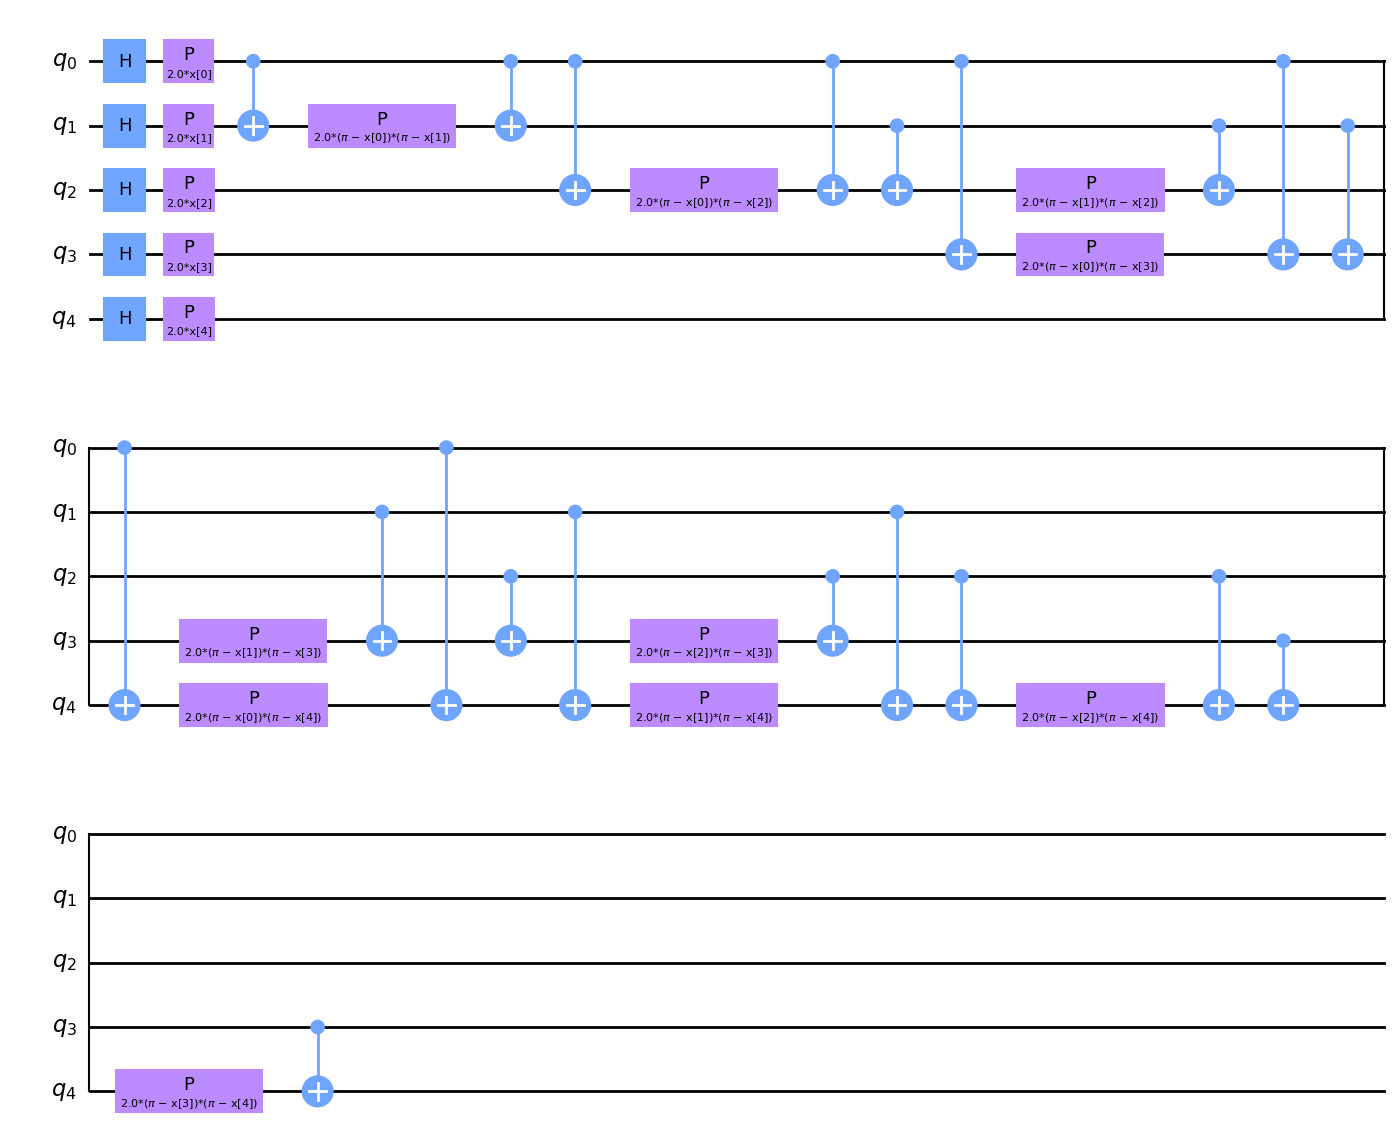

In [212]:
num_features = 5   
print(f"Number of features: {num_features}")

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

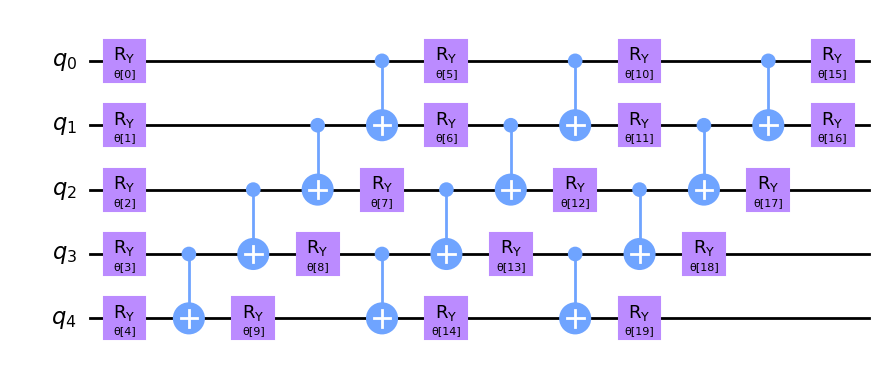

In [213]:
ansatz = RealAmplitudes(num_qubits=5, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [214]:
# optimizer = COBYLA(maxiter=100)

In [215]:
# sampler = Sampler()

In [216]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [217]:

# vqc = VQC(
#     sampler=sampler,
#     feature_map=feature_map,
#     ansatz=ansatz,
#     optimizer=optimizer,
#     callback=callback_graph,
# )

# # clear objective value history
# objective_func_vals = []

# start = time.time()
# vqc.fit(train_features, train_labels)
# elapsed = time.time() - start

# print(f"Training time: {round(elapsed)} seconds")


In [218]:
# train_score_q4 = vqc.score(train_features, train_labels)
# test_score_q4 = vqc.score(test_features, test_labels)

# print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
# print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

<Axes: >

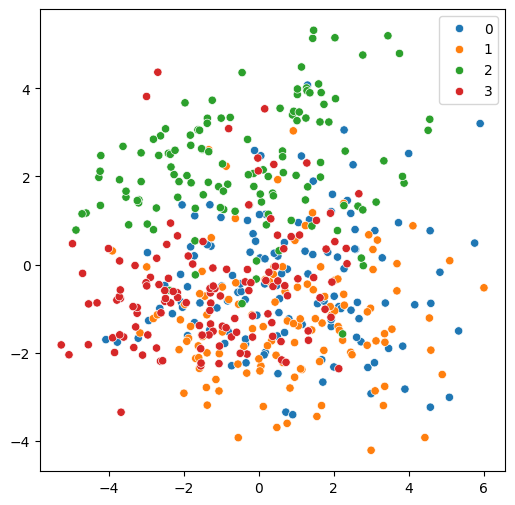

In [219]:
components = 5
features = PCA(n_components=components).fit_transform(features_X)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [220]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [ ]:
def train_svc_model(train_features, train_labels, test_features, test_labels,components=3):
    """Train Support Vector Classifier (baseline classical method)"""
    svc = SVC()  # Classical SVM with RBF kernel
    svc.fit(train_features, train_labels)

    # Evaluate performance
    train_score_c2 = svc.score(train_features, train_labels)
    test_score_c2 = svc.score(test_features, test_labels)

    print(f"Classical SVC (after PCA with {components} components) on the training dataset: {train_score_c2:.2f}")
    print(f"Classical SVC (after PCA with {components} components) on the test dataset:     {test_score_c2:.2f}")
    
    return train_score_c2, test_score_c2

def train_mlp_model(train_features, train_labels, test_features, test_labels, components=3):
    """Train Multi-Layer Perceptron (baseline classical neural network)"""
    model = MLPClassifier(max_iter=100)  # Neural network classifier
    model.fit(train_features, train_labels)

    # Evaluate performance
    train_score_c2 = model.score(train_features, train_labels)
    test_score_c2 = model.score(test_features, test_labels)

    print(f"Classical MLP (after PCA with {components} components) on the training dataset: {train_score_c2:.2f}")
    print(f"Classical MLP (after PCA with {components} components) on the test dataset:     {test_score_c2:.2f}")
    
    return train_score_c2, test_score_c2

In [ ]:
def train_vqc_model(train_features, train_labels, test_features, test_labels,feature_map=None, ansatz_reps=3, maxiter=40, callback_graph=callback_graph):
    """
    Train VQC with ZZFeatureMap (default) or custom feature map.
    Standard quantum machine learning pipeline implementation.
    """

    num_features = train_features.shape[1]
    sampler = Sampler()  # Quantum state sampler

    # Use ZZFeatureMap as default or provided feature map
    if feature_map is None:
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    else:
        feature_map = feature_map

    # Create variational ansatz circuit
    ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps)

    # Classical optimizer for parameter optimization
    optimizer = COBYLA(maxiter=maxiter)

    # Assemble Variational Quantum Classifier
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
    )

    # Train the quantum model
    vqc.fit(train_features, train_labels)
    
    # Evaluate on both training and test sets
    train_score_q2_ra = vqc.score(train_features, train_labels)
    test_score_q2_ra = vqc.score(test_features, test_labels)
    
    return train_score_q2_ra, test_score_q2_ra

In [223]:
svc_train_5, svc_test_5 = train_svc_model(train_features, train_labels, test_features, test_labels, components=components)
mlp_train_5, mlp_test_5 = train_mlp_model(train_features, train_labels, test_features, test_labels, components=components)

Classical SVC (after PCA with 5 components) on the training dataset: 0.74
Classical SVC (after PCA with 5 components) on the test dataset:     0.67
Classical MLP (after PCA with 5 components) on the training dataset: 0.71
Classical MLP (after PCA with 5 components) on the test dataset:     0.65


/Users/rithvikrajesh/Proper_Project/QC_Project/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


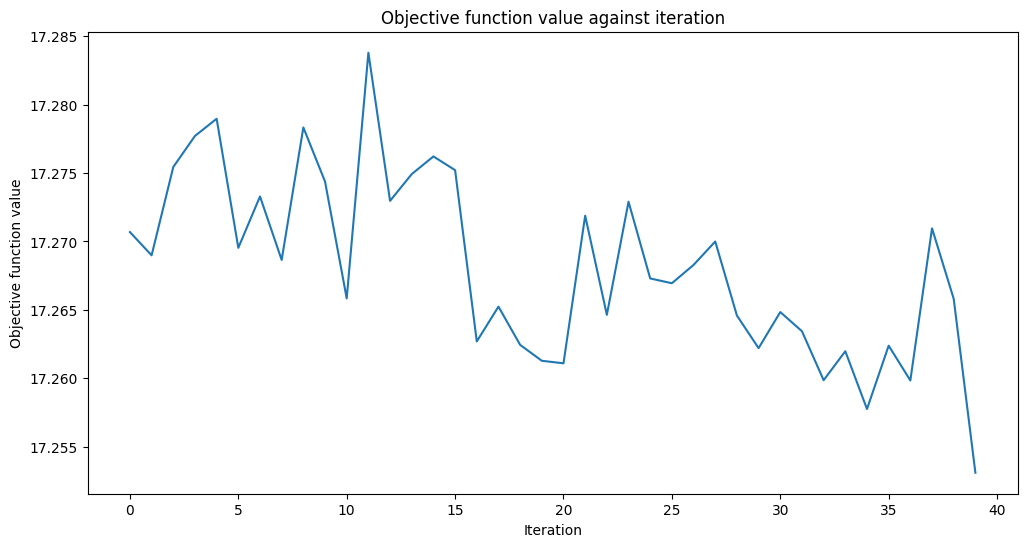

Training time: 99 seconds
Quantum VQC (after PCA with 5 components) on the training dataset using RealAmplitudes: 0.28
Quantum VQC (after PCA with 5 components) on the test dataset using RealAmplitudes:     0.24
Quantum VQC (after PCA with 5 components) on the training dataset using RealAmplitudes: 0.28
Quantum VQC (after PCA with 5 components) on the test dataset using RealAmplitudes:     0.24


In [ ]:
vqc_train_5, vqc_test_5 = train_vqc_model(train_features, train_labels, test_features, test_labels,feature_map = )
print(f"Quantum VQC (after PCA with {components} components) on the training dataset using RealAmplitudes: {vqc_train_5:.2f}")
print(f"Quantum VQC (after PCA with {components} components) on the test dataset using RealAmplitudes:     {vqc_test_5:.2f}")

<Axes: >

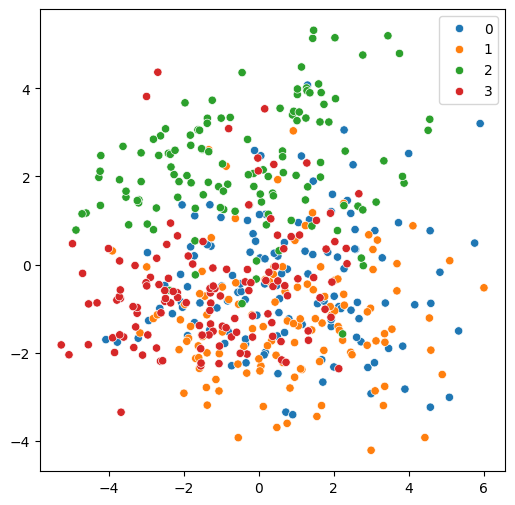

In [225]:
components = 2
features = PCA(n_components=components).fit_transform(features_X)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [226]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [227]:
svc_train_2, svc_test_2 = train_svc_model(train_features, train_labels, test_features, test_labels, components=components)
mlp_train_2, mlp_test_2 = train_mlp_model(train_features, train_labels, test_features, test_labels, components=components)

Classical SVC (after PCA with 2 components) on the training dataset: 0.56
Classical SVC (after PCA with 2 components) on the test dataset:     0.58
Classical MLP (after PCA with 2 components) on the training dataset: 0.56
Classical MLP (after PCA with 2 components) on the test dataset:     0.57


/Users/rithvikrajesh/Proper_Project/QC_Project/.env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


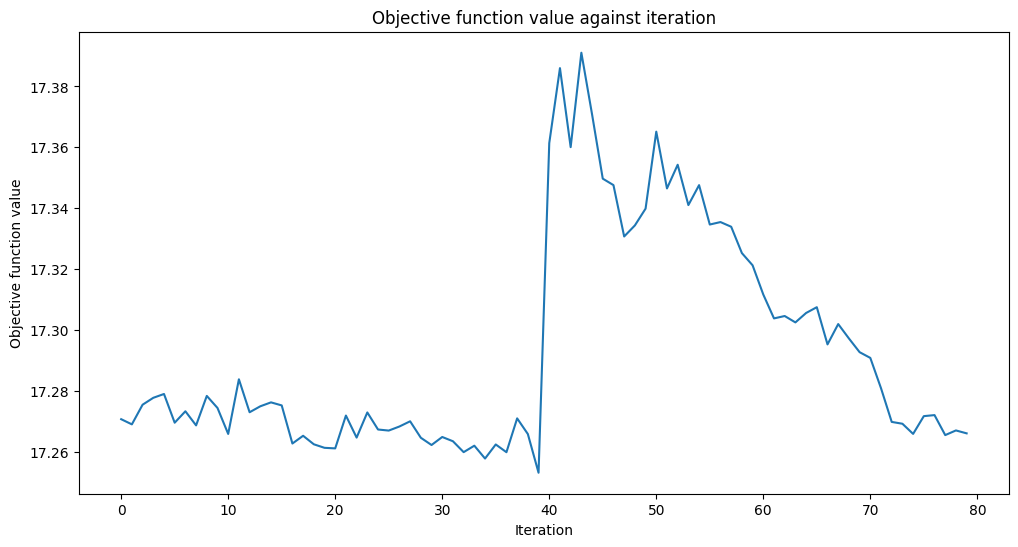

Training time: 59 seconds
Quantum VQC (after PCA with 2 components) on the training dataset using RealAmplitudes: 0.27
Quantum VQC (after PCA with 2 components) on the test dataset using RealAmplitudes:     0.22
Quantum VQC (after PCA with 2 components) on the training dataset using RealAmplitudes: 0.27
Quantum VQC (after PCA with 2 components) on the test dataset using RealAmplitudes:     0.22


In [228]:
vqc_train_2, vqc_test_2 = train_vqc_model(train_features, train_labels, test_features, test_labels)
print(f"Quantum VQC (after PCA with {components} components) on the training dataset using RealAmplitudes: {vqc_train_2:.2f}")
print(f"Quantum VQC (after PCA with {components} components) on the test dataset using RealAmplitudes:     {vqc_test_2:.2f}")

# 📊 **EXPERIMENT SUMMARY**

This section provides a comprehensive comparison of all models across different PCA configurations.

In [229]:
# Collect experiment configuration details
num_samples = len(X)
num_classes = len(np.unique(labels))
unique_labels = np.unique(y)  # Original labels before encoding
feature_map_type = "ZZFeatureMap"
ansatz_type = "RealAmplitudes"

print("EXPERIMENT CONFIGURATION")
print("=" * 50)
print(f"Total Samples: {num_samples}")
print(f"Number of Classes: {num_classes}")
print(f"Class Labels: {list(unique_labels)}")
print(f"Feature Map: {feature_map_type} (reps=1)")
print(f"Ansatz: {ansatz_type} (reps=3)")
print(f"Optimizer: COBYLA (maxiter=40)")
print(f"Random Seed: {algorithm_globals.random_seed}")
print(f"Train/Test Split: 80%/20%")

EXPERIMENT CONFIGURATION
Total Samples: 500
Number of Classes: 4
Class Labels: ['bicycle', 'car', 'clock', 'fish']
Feature Map: ZZFeatureMap (reps=1)
Ansatz: RealAmplitudes (reps=3)
Optimizer: COBYLA (maxiter=40)
Random Seed: 123
Train/Test Split: 80%/20%


In [230]:
import pandas as pd

# Create comprehensive results summary
print("\n\nMODEL PERFORMANCE COMPARISON")
print("=" * 80)

# Create results dataframe
results_data = {
    'Model': ['SVC (PCA-5)', 'MLP (PCA-5)', 'VQC (PCA-5)', 'SVC (PCA-2)', 'MLP (PCA-2)', 'VQC (PCA-2)'],
    'Features': ['5 Components', '5 Components', '5 Components', '2 Components', '2 Components', '2 Components'],
    'Train Score': [svc_train_5, mlp_train_5, vqc_train_5, svc_train_2, mlp_train_2, vqc_train_2],
    'Test Score': [svc_test_5, mlp_test_5, vqc_test_5, svc_test_2, mlp_test_2, vqc_test_2],
    'Model Type': ['Classical', 'Classical', 'Quantum', 'Classical', 'Classical', 'Quantum']
}


results_df = pd.DataFrame(results_data)

# Display the results table
print(results_df.to_string(index=False, float_format='%.4f'))

# Find best performing models
print(f"\n\nBEST PERFORMERS")
print("=" * 40)

# Convert scores to numeric for comparison (handle 'N/A' values)
numeric_test_scores = []
model_names = []
for i, score in enumerate(results_data['Test Score']):
    if score != 'N/A' and isinstance(score, (int, float)):
        numeric_test_scores.append(score)
        model_names.append(results_data['Model'][i])

if numeric_test_scores:
    best_idx = np.argmax(numeric_test_scores)
    best_score = numeric_test_scores[best_idx]
    best_model = model_names[best_idx]
    
    print(f" Best Test Performance: {best_model} with {best_score:.4f}")
    
    # Best by category
    classical_scores = [(score, name) for score, name in zip(numeric_test_scores, model_names) if 'VQC' not in name]
    quantum_scores = [(score, name) for score, name in zip(numeric_test_scores, model_names) if 'VQC' in name]
    
    if classical_scores:
        best_classical = max(classical_scores, key=lambda x: x[0])
        print(f"🔧 Best Classical Model: {best_classical[1]} with {best_classical[0]:.4f}")
    
    if quantum_scores:
        best_quantum = max(quantum_scores, key=lambda x: x[0])
        print(f" Best Quantum Model: {best_quantum[1]} with {best_quantum[0]:.4f}")

print("\n\n KEY INSIGHTS")
print("=" * 40)
print("• PCA dimensionality reduction impact on different models")
print("• Quantum vs Classical performance comparison")
print("• Trade-offs between model complexity and performance")
print(f"• Dataset: {num_samples} samples, {num_classes} classes ({', '.join(map(str, unique_labels))})")
print(f"• Feature Map: {feature_map_type}, Ansatz: {ansatz_type}")



MODEL PERFORMANCE COMPARISON
      Model     Features  Train Score  Test Score Model Type
SVC (PCA-5) 5 Components       0.7425      0.6700  Classical
MLP (PCA-5) 5 Components       0.7100      0.6500  Classical
VQC (PCA-5) 5 Components       0.2775      0.2400    Quantum
SVC (PCA-2) 2 Components       0.5650      0.5800  Classical
MLP (PCA-2) 2 Components       0.5575      0.5700  Classical
VQC (PCA-2) 2 Components       0.2700      0.2200    Quantum


BEST PERFORMERS
 Best Test Performance: SVC (PCA-5) with 0.6700
🔧 Best Classical Model: SVC (PCA-5) with 0.6700
 Best Quantum Model: VQC (PCA-5) with 0.2400


 KEY INSIGHTS
• PCA dimensionality reduction impact on different models
• Quantum vs Classical performance comparison
• Trade-offs between model complexity and performance
• Dataset: 500 samples, 4 classes (bicycle, car, clock, fish)
• Feature Map: ZZFeatureMap, Ansatz: RealAmplitudes


# 🔬 **QUANTUM ENCODING COMPARISON**

This section implements and compares different quantum feature encoding methods across PCA settings.

In [ ]:
from qiskit.circuit import ParameterVector

def quantum_feature_encoding(encoding_type='angle', feature_dimension=None, qubit_precision=None, scaling_factor=0.01):
    """
    Create a parameterized quantum circuit for feature encoding.
    
    Parameters:
    - encoding_type: 'angle', 'basis', or 'amplitude'
    - feature_dimension: number of features in your data
    - qubit_precision: specific number of qubits (for basis/amplitude encoding)
    - scaling_factor: scaling factor for angle encoding
    
    Returns:
    - QuantumCircuit that can be used as feature_map in VQC
    """
    
    # Route to appropriate encoding method
    if encoding_type == 'angle':
        return create_angle_encoding_circuit(feature_dimension, scaling_factor)
    elif encoding_type in ['basis', 'amplitude']:
        return create_amplitude_encoding_circuit(feature_dimension, qubit_precision)
    else:
        raise ValueError("encoding_type must be 'angle', 'basis', or 'amplitude'")

def create_angle_encoding_circuit(feature_dimension, scaling_factor=0.01):
    """Create parameterized angle encoding circuit - each feature maps to RY rotation"""
    
    n_qubits = feature_dimension  # One qubit per feature
    qc = QuantumCircuit(n_qubits, name='AngleEncoding')
    
    # Create parameter vector for features
    feature_params = ParameterVector('x', feature_dimension)
    
    # Apply RY rotation for each feature (angle encoding)
    for i, param in enumerate(feature_params):
        scaled_param = param * scaling_factor  # Scale to prevent large rotations
        qc.ry(scaled_param, i)
    
    return qc

def create_amplitude_encoding_circuit(feature_dimension, qubit_precision=None):
    """
    Create parameterized amplitude encoding circuit.
    Uses rotation + entanglement to approximate amplitude encoding.
    """
    
    # Calculate number of qubits needed (log₂ scaling)
    if qubit_precision is None:
        n_qubits = max(1, int(np.ceil(np.log2(feature_dimension))))
    else:
        n_qubits = qubit_precision
    
    target_dim = 2 ** n_qubits
    
    qc = QuantumCircuit(n_qubits, name='AmplitudeEncoding')
    feature_params = ParameterVector('x', min(feature_dimension, target_dim))
    
    # Use rotations + entanglement to approximate amplitude encoding
    for i, param in enumerate(feature_params[:n_qubits]):
        qc.ry(param * 0.01, i)  # Scale parameters appropriately
        if i > 0:
            qc.cx(i-1, i)  # Add entanglement between adjacent qubits
    
    return qc

In [ ]:
def preprocess_features_for_encoding(train_features, test_features, encoding_type='angle'):
    """
    Preprocess features according to the quantum encoding type.
    Different encodings require different data preparation.
    """
    
    if encoding_type == 'angle':
        # Scale features for angle encoding (normalize by max values)
        max_vals = np.max(np.abs(train_features), axis=0)
        max_vals[max_vals == 0] = 1  # Avoid division by zero
        
        train_processed = train_features / max_vals
        test_processed = test_features / max_vals
        
        return train_processed, test_processed, train_features.shape[1]
    
    elif encoding_type in ['basis', 'amplitude']:
        # Apply basis/amplitude encoding preprocessing
        def process_samples(features):
            processed = []
            for sample in features:
                # Step 1: Normalize each sample
                norm = np.linalg.norm(sample)
                if norm > 0:
                    normalized = sample / norm
                else:
                    normalized = sample
                
                # Step 2: Pad to power of 2 (required for quantum states)
                n_features = len(normalized)
                n_qubits = max(1, int(np.ceil(np.log2(n_features))))
                target_dim = 2 ** n_qubits
                
                if len(normalized) <= target_dim:
                    padded = np.zeros(target_dim)
                    padded[:len(normalized)] = normalized
                else:
                    padded = normalized[:target_dim]
                
                # Step 3: Renormalize after padding
                padded_norm = np.linalg.norm(padded)
                if padded_norm > 0:
                    padded = padded / padded_norm
                
                processed.append(padded)
            
            return np.array(processed)
        
        # Process both train and test sets
        train_processed = process_samples(train_features)
        test_processed = process_samples(test_features)
        
        # For amplitude encoding, we need fewer qubits than features
        n_qubits = max(1, int(np.ceil(np.log2(train_features.shape[1]))))
        
        return train_processed, test_processed, n_qubits
    
    else:
        return train_features, test_features, train_features.shape[1]

def train_vqc_with_custom_encoding(train_features, train_labels, test_features, test_labels,
                                 encoding_type='angle', qubit_precision=None, 
                                 scaling_factor=0.01, ansatz_reps=3, maxiter=40, 
                                 callback_graph=None):
    """
    Train VQC with custom quantum encoding methods.
    Complete pipeline: preprocess → encode → train → evaluate
    """
    from qiskit.primitives import StatevectorSampler as Sampler
    from qiskit_machine_learning.optimizers import COBYLA
    from qiskit_machine_learning.algorithms.classifiers import VQC
    import time
    
    # Step 1: Preprocess features according to encoding type
    train_processed, test_processed, effective_features = preprocess_features_for_encoding(
        train_features, test_features, encoding_type
    )
    
    # Step 2: Create quantum feature map
    if encoding_type == 'angle':
        feature_map = quantum_feature_encoding(
            encoding_type='angle',
            feature_dimension=effective_features,
            scaling_factor=scaling_factor
        )
        n_qubits = effective_features
    else:
        feature_map = quantum_feature_encoding(
            encoding_type=encoding_type,
            feature_dimension=train_features.shape[1],
            qubit_precision=qubit_precision
        )
        n_qubits = feature_map.num_qubits
    
    # Step 3: Create quantum components
    sampler = Sampler()  # Quantum state sampler
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=ansatz_reps)  # Variational ansatz
    optimizer = COBYLA(maxiter=maxiter)  # Classical optimizer
    
    # Step 4: Create VQC classifier
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
    )
    
    # Print configuration info
    print(f"Encoding type: {encoding_type}")
    print(f"Number of qubits: {n_qubits}")
    print(f"Original features: {train_features.shape[1]}")
    print(f"Processed features: {train_processed.shape[1]}")
    print(f"Feature map: {feature_map.name}")
    
    # Step 5: Train the quantum model
    start = time.time()
    vqc.fit(train_processed, train_labels)
    elapsed = time.time() - start
    
    print(f"Training time: {round(elapsed)} seconds")
    
    # Step 6: Evaluate performance
    train_score = vqc.score(train_processed, train_labels)
    test_score = vqc.score(test_processed, test_labels)
    
    return train_score, test_score, vqc, feature_map

In [236]:
print("\n\n📊 Testing with PCA = 2 components")
print("-" * 50)

components = 2
features_pca2 = PCA(n_components=components).fit_transform(features_X)
train_features_pca2, test_features_pca2, train_labels_current, test_labels_current = train_test_split(
    features_pca2, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

# Test different encodings for PCA-2
pca2_results = {}

for encoding in encoding_types:
    print(f"\n🔬 Testing {encoding.upper()} encoding with PCA-2...")
    try:
        if encoding == 'angle':
            train_score, test_score, model, feature_map = train_vqc_with_custom_encoding(
                train_features_pca2, train_labels_current, test_features_pca2, test_labels_current,
                encoding_type='angle',
                scaling_factor=0.1,
                ansatz_reps=2,
                maxiter=30
            )
        else:
            train_score, test_score, model, feature_map = train_vqc_with_custom_encoding(
                train_features_pca2, train_labels_current, test_features_pca2, test_labels_current,
                encoding_type=encoding,
                qubit_precision=2,  # Use 2 qubits for amplitude/basis encoding
                ansatz_reps=2,
                maxiter=30
            )
        
        pca2_results[encoding] = {
            'train_score': train_score,
            'test_score': test_score,
            'feature_map': feature_map.name,
            'n_qubits': feature_map.num_qubits
        }
        
        print(f"✅ {encoding.capitalize()} Encoding Results:")
        print(f"   Train Score: {train_score:.4f}")
        print(f"   Test Score: {test_score:.4f}")
        print(f"   Qubits Used: {feature_map.num_qubits}")
        
    except Exception as e:
        print(f"❌ Error with {encoding} encoding: {str(e)}")
        pca2_results[encoding] = {
            'train_score': 'Error',
            'test_score': 'Error',
            'feature_map': 'N/A',
            'n_qubits': 'N/A'
        }

all_results['PCA-2'] = pca2_results

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.




📊 Testing with PCA = 2 components
--------------------------------------------------

🔬 Testing ANGLE encoding with PCA-2...
Encoding type: angle
Number of qubits: 2
Original features: 2
Processed features: 2
Feature map: AngleEncoding
Training time: 35 seconds
Training time: 35 seconds


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


✅ Angle Encoding Results:
   Train Score: 0.2175
   Test Score: 0.2800
   Qubits Used: 2

🔬 Testing AMPLITUDE encoding with PCA-2...
Encoding type: amplitude
Number of qubits: 2
Original features: 2
Processed features: 2
Feature map: AmplitudeEncoding
Training time: 36 seconds
Training time: 36 seconds


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


✅ Amplitude Encoding Results:
   Train Score: 0.2425
   Test Score: 0.2100
   Qubits Used: 2

🔬 Testing BASIS encoding with PCA-2...
Encoding type: basis
Number of qubits: 2
Original features: 2
Processed features: 2
Feature map: AmplitudeEncoding
Training time: 36 seconds
Training time: 36 seconds
✅ Basis Encoding Results:
   Train Score: 0.2575
   Test Score: 0.2600
   Qubits Used: 2
✅ Basis Encoding Results:
   Train Score: 0.2575
   Test Score: 0.2600
   Qubits Used: 2


In [237]:
print("\n\n🎯 COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)

# Create comprehensive summary
print(f"\n📋 EXPERIMENT CONFIGURATION:")
print(f"   • Dataset: {len(features_X)} samples, {features_X.shape[1]} original features")
print(f"   • Classes: {len(np.unique(labels))} ({np.unique(labels)})")
print(f"   • Train/Test Split: 80/20")
print(f"   • Random Seed: {algorithm_globals.random_seed}")

print(f"\n🔬 QUANTUM ALGORITHMS TESTED:")
print(f"   • Variational Quantum Classifier (VQC)")
print(f"   • Ansatz: RealAmplitudes (2 repetitions)")
print(f"   • Optimizer: COBYLA (30 iterations)")

print(f"\n📊 ENCODING METHODS COMPARED:")
print(f"   • Angle Encoding: RY rotations per feature")
print(f"   • Amplitude Encoding: Features as quantum amplitudes")
print(f"   • Basis Encoding: Features as computational basis states")

print(f"\n🎚️ PCA CONFIGURATIONS:")
print(f"   • PCA-5: 5 principal components")
print(f"   • PCA-2: 2 principal components")

print("\n\n📈 DETAILED RESULTS BY ENCODING AND PCA SETTING")
print("=" * 80)

# Classical baselines from existing variables
classical_baselines = {
    'PCA-5': {
        'SVC': {'train': svc_train_5, 'test': svc_test_5},
        'MLP': {'train': mlp_train_5, 'test': mlp_test_5},
        'VQC_ZZ': {'train': vqc_train_5, 'test': vqc_test_5}
    },
    'PCA-2': {
        'SVC': {'train': svc_train_2, 'test': svc_test_2},
        'MLP': {'train': mlp_train_2, 'test': mlp_test_2},
        'VQC_ZZ': {'train': vqc_train_2, 'test': vqc_test_2}
    }
}

for pca_setting in ['PCA-5', 'PCA-2']:
    print(f"\n🔸 {pca_setting} RESULTS:")
    print("-" * 60)
    
    # Header
    print(f"{'Algorithm':<20} {'Feature Map':<18} {'Qubits':<8} {'Train Score':<12} {'Test Score':<12}")
    print("-" * 70)
    
    # Classical baselines
    svc_scores = classical_baselines[pca_setting]['SVC']
    mlp_scores = classical_baselines[pca_setting]['MLP']
    vqc_zz_scores = classical_baselines[pca_setting]['VQC_ZZ']
    
    print(f"{'SVM':<20} {'Classical':<18} {'N/A':<8} {svc_scores['train']:<12.4f} {svc_scores['test']:<12.4f}")
    print(f"{'MLP':<20} {'Classical':<18} {'N/A':<8} {mlp_scores['train']:<12.4f} {mlp_scores['test']:<12.4f}")
    print(f"{'VQC':<20} {'ZZFeatureMap':<18} {'4':<8} {vqc_zz_scores['train']:<12.4f} {vqc_zz_scores['test']:<12.4f}")
    
    # Quantum encoding results
    if pca_setting in all_results:
        for encoding, results in all_results[pca_setting].items():
            if isinstance(results['train_score'], float):
                print(f"{'VQC':<20} {encoding.capitalize()+'Encoding':<18} {str(results['n_qubits']):<8} {results['train_score']:<12.4f} {results['test_score']:<12.4f}")
            else:
                print(f"{'VQC':<20} {encoding.capitalize()+'Encoding':<18} {'N/A':<8} {'Error':<12} {'Error':<12}")

print("\n\n🏆 PERFORMANCE RANKING")
print("=" * 50)

# Collect all test scores for ranking
all_scores = []

for pca_setting in ['PCA-5', 'PCA-2']:
    # Add classical scores
    svc_score = classical_baselines[pca_setting]['SVC']['test']
    mlp_score = classical_baselines[pca_setting]['MLP']['test']
    vqc_zz_score = classical_baselines[pca_setting]['VQC_ZZ']['test']
    
    all_scores.append((f"SVM ({pca_setting})", svc_score))
    all_scores.append((f"MLP ({pca_setting})", mlp_score))
    all_scores.append((f"VQC-ZZ ({pca_setting})", vqc_zz_score))
    
    # Add quantum encoding scores
    if pca_setting in all_results:
        for encoding, results in all_results[pca_setting].items():
            if isinstance(results['test_score'], float):
                all_scores.append((f"VQC-{encoding.capitalize()} ({pca_setting})", results['test_score']))

# Sort by test score
all_scores.sort(key=lambda x: x[1], reverse=True)

print(f"{'Rank':<5} {'Model':<25} {'Test Score':<12}")
print("-" * 42)
for rank, (model, score) in enumerate(all_scores, 1):
    print(f"{rank:<5} {model:<25} {score:<12.4f}")

print("\n\n💡 KEY INSIGHTS")
print("=" * 50)
print("• Compare classical vs quantum performance")
print("• Analyze the impact of feature dimensionality (PCA-5 vs PCA-2)")
print("• Evaluate different quantum encoding strategies")
print("• Consider qubit efficiency vs performance trade-offs")

best_model = all_scores[0]
print(f"\n🥇 BEST PERFORMING MODEL: {best_model[0]} with {best_model[1]:.4f} test accuracy")

print("\n✅ Analysis Complete!")
print("=" * 80)



🎯 COMPREHENSIVE RESULTS SUMMARY

📋 EXPERIMENT CONFIGURATION:
   • Dataset: 500 samples, 19 original features
   • Classes: 4 ([0 1 2 3])
   • Train/Test Split: 80/20
   • Random Seed: 123

🔬 QUANTUM ALGORITHMS TESTED:
   • Variational Quantum Classifier (VQC)
   • Ansatz: RealAmplitudes (2 repetitions)
   • Optimizer: COBYLA (30 iterations)

📊 ENCODING METHODS COMPARED:
   • Angle Encoding: RY rotations per feature
   • Amplitude Encoding: Features as quantum amplitudes
   • Basis Encoding: Features as computational basis states

🎚️ PCA CONFIGURATIONS:
   • PCA-5: 5 principal components
   • PCA-2: 2 principal components


📈 DETAILED RESULTS BY ENCODING AND PCA SETTING

🔸 PCA-5 RESULTS:
------------------------------------------------------------
Algorithm            Feature Map        Qubits   Train Score  Test Score  
----------------------------------------------------------------------
SVM                  Classical          N/A      0.7425       0.6700      
MLP                 